# 🛠️ Anomaly Detection Visualization

This notebook loads anomaly detection results and visualizes anomalies detected by:
- Linear Regression (LR)
- GPT-based Isolation Forest

It highlights the **training and test periods**, and marks the **failure alarm time**.



In [2]:
import os
import pickle
import zipfile
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
# --- CONFIGURATION ---
DATASET_NAME = 'DS2'
RESULTS_FILE = f'./results_{DATASET_NAME.lower()}.csv'
ZIP_FILE = f'{DATASET_NAME}_data.zip'  # New: single ZIP archive containing both .pkl files


In [18]:
# --- LOAD DATA ---
# Ensure files exist
if not os.path.exists(ZIP_FILE):
    raise FileNotFoundError(f"Dataset zip file not found: {ZIP_FILE}")
if not os.path.exists(RESULTS_FILE):
    raise FileNotFoundError(f"Results file not found: {RESULTS_FILE}")

# Load anomaly detection results
results_df = pd.read_csv(RESULTS_FILE, index_col=0, parse_dates=True)

# Load train and test data from ZIP file
with zipfile.ZipFile(ZIP_FILE, 'r') as z:
    with z.open(f'{DATASET_NAME}_train_data.pkl') as f_train:
        train_data = pickle.load(f_train)
    with z.open(f'{DATASET_NAME}_test_data.pkl') as f_test:
        test_data = pickle.load(f_test)

# Extract individual components
train_df = train_data['train']
test_df = test_data['test']
failure_alarm = test_data['failure alarm']

print(f"✅ Data loaded from {DATASET_NAME}_data.zip")
print(f"📍 Failure Alarm Timestamp: {failure_alarm.name}")


✅ Data loaded from DS2_data.zip
📍 Failure Alarm Timestamp: 2022-11-20 15:50:00


In [19]:
# Print dataset info
print("\n--- Train Set Overview ---")
print(f"Shape: {train_df.shape[0]} rows × {train_df.shape[1]} columns")
print("Columns preview:", list(train_df.columns[:5]), "...\n")
display(train_df.iloc[:, :5].head())



--- Train Set Overview ---
Shape: 13248 rows × 302 columns
Columns preview: ['Wind speed (m/s)', 'Wind speed, Standard deviation (m/s)', 'Wind speed, Minimum (m/s)', 'Wind speed, Maximum (m/s)', 'Long Term Wind (m/s)'] ...



,Wind speed (m/s),"Wind speed, Standard deviation (m/s)","Wind speed, Minimum (m/s)","Wind speed, Maximum (m/s)",Long Term Wind (m/s)
2022-07-20 15:50:00,7.268841,0.786316,6.038444,9.391945,5.3
2022-07-20 16:00:00,7.401451,1.123004,5.406205,10.046458,5.3
2022-07-20 16:10:00,7.956488,1.043359,5.537999,9.827421,5.3
2022-07-20 16:20:00,7.711408,1.086671,5.700235,9.343682,5.3
2022-07-20 16:30:00,7.428441,1.095665,4.550845,9.690802,5.3


In [20]:
# Extract test/train indexes
train_start = train_df.index[0]
train_end =train_df.index[-1]
test_start = test_df.index[0]
test_end = test_df.index[-1]
failure_time = failure_alarm.name

In [21]:
# --- EXTRACT SERIES USING TEST INDEX ---
LR_residual_series = results_df['LR_residuals']
gpt_score_series = results_df['gpt_scores']

# Identify anomaly points
anomaly_points_LR = results_df[results_df['LR'] == 1]
anomaly_points_GPT = results_df[results_df['CHATGPT'] == 1]


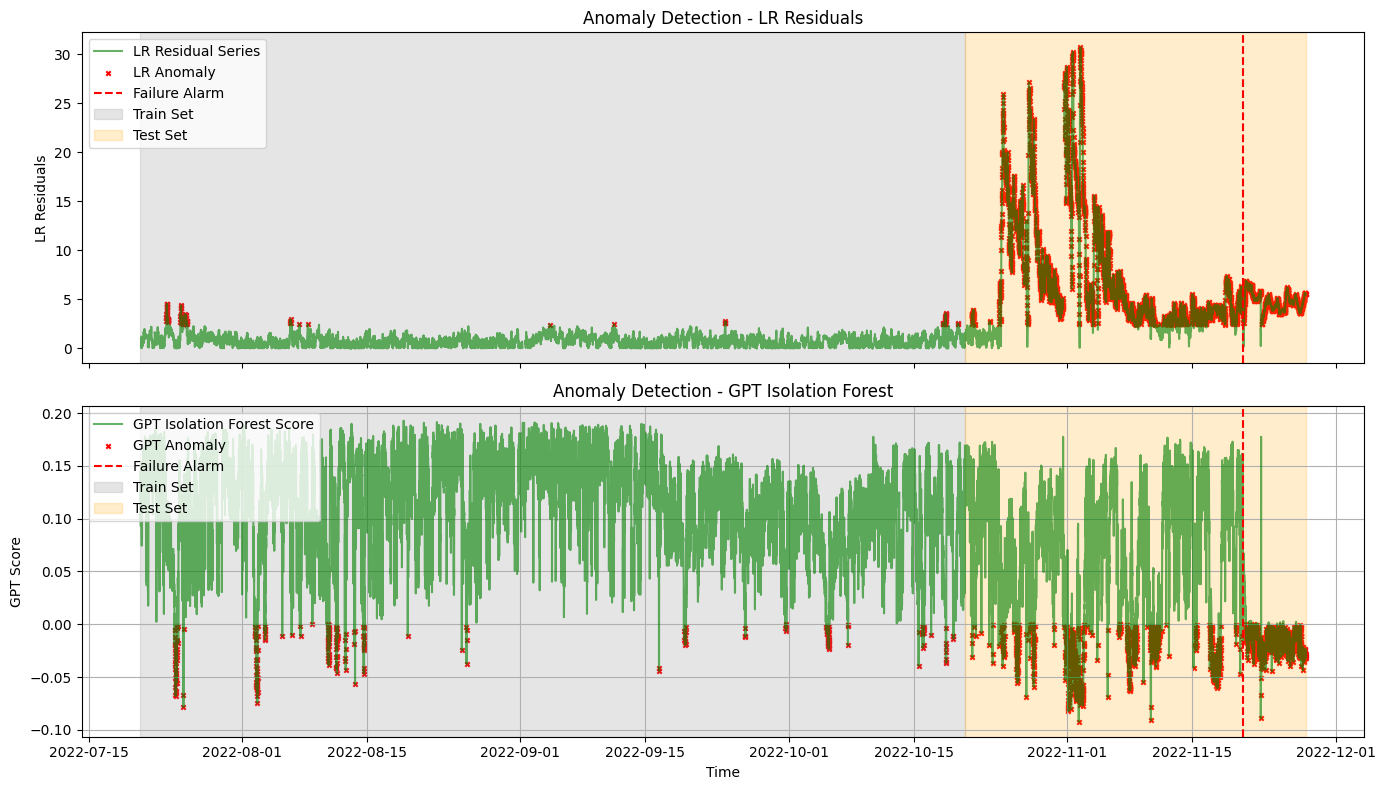

In [23]:
# --- PLOT ANOMALIES ---

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# --- Top Plot: LR Residuals ---
ax1.plot(LR_residual_series, label='LR Residual Series', color='green', alpha=0.6)
ax1.scatter(anomaly_points_LR.index,
            LR_residual_series.loc[anomaly_points_LR.index],
            marker='x', color='red', label='LR Anomaly', s=10)
ax1.axvline(x=failure_time, color='red', linestyle='--', label='Failure Alarm')
ax1.axvspan(train_start, train_end, color='gray', alpha=0.2, label='Train Set')
ax1.axvspan(test_start, test_end, color='orange', alpha=0.2, label='Test Set')
ax1.set_ylabel('LR Residuals')
ax1.set_title('Anomaly Detection - LR Residuals')
ax1.legend(loc='upper left')

# --- Bottom Plot: GPT Isolation Forest ---
ax2.plot(gpt_score_series, label='GPT Isolation Forest Score', color='green', alpha=0.6)
ax2.scatter(anomaly_points_GPT.index,
            gpt_score_series.loc[anomaly_points_GPT.index],
            marker='x', color='red', label='GPT Anomaly', s=10)
ax2.axvline(x=failure_time, color='red', linestyle='--', label='Failure Alarm')
ax2.axvspan(train_start, train_end, color='gray', alpha=0.2, label='Train Set')
ax2.axvspan(test_start, test_end, color='orange', alpha=0.2, label='Test Set')
ax2.set_ylabel('GPT Score')
ax2.set_xlabel('Time')
ax2.set_title('Anomaly Detection - GPT Isolation Forest')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.grid(True)
plt.show()
